# Machine Learning Final Project
#### Erik Wilder, Sarah Dietch, Bowen Ma, Muskan Yadav

In [47]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import itertools

import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt

import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks
from keras.models import Sequential
from keras.layers import *
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron, LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
file_dir = 'C:/Users/ewild/Documents/School/2022 Spring/7243 - Machine Learning/Project/XN_Project/XN_Project/'
os.chdir(file_dir)

labels = pd.read_csv(file_dir + 'hemorrhage-labels.csv')
display(labels.head())

epid = pd.read_csv(file_dir + 'Results_Epidural.csv') 
intrap = pd.read_csv(file_dir + 'Results_Intraparenchymal.csv') 
multi = pd.read_csv(file_dir + 'Results_Multiple.csv') 
suba = pd.read_csv(file_dir + 'Results_Subarachnoid.csv') 
subd = pd.read_csv(file_dir + 'Results_Subdural.csv') 

# NOTE: seems that the intraventricular Results .csv was not uploaded to Canvas, we need to ask Wang

# Per Prof. Wang: "Majority Label should be used"
#display(epid.head())
#display(intrap.head())
#display(multi.head())
#display(suba.head())
#display(subd.head())

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf,0,0,0,0,0,0
1,ID_000039fa0,0,0,0,0,0,0
2,ID_00005679d,0,0,0,0,0,0
3,ID_00008ce3c,0,0,0,0,0,0
4,ID_0000950d7,0,0,0,0,0,0


## Data Cleaning & Filters

In [3]:
"""
In the conditions list, the in-line comment explains which categorical dummy variable that relates to the column.
These are explained here as well: 
normal case = 0 (i.e. no hemorrhage)
epidural = 1; intraparenchymal = 2; intraventricular = 3; subarachnoid = 4; subdural = 5; multiple = 6
"""
conditions = [
    # the 'multiple' case (i.e. has a 1 in two or more columns, not including 'any' column)
    # .gt(1) :=  test for greater than 1
    labels[['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].sum(1).gt(1),   # 6
    labels['epidural'] == 1,   # 1
    labels['intraparenchymal'] == 1,   # 2
    labels['intraventricular'] == 1,   # 3
    labels['subarachnoid'] == 1,   #4
    labels['subdural'] == 1,   #5
]
outputs = [6, 1, 2, 3, 4, 5]

# np.nan characteristic sets the default case (i.e. the 'normal' or no hemorrhage case as NaN so we can remove easily)
# this could be changed to a zero if necessary 
dummy = np.select(conditions, outputs, 0)
dummy = pd.Series(dummy)
dummy.name = "category"

labels_cat = pd.concat([labels, dummy], axis=1)
labels_cat['Image'] =  labels_cat['Image'] + '.jpg'

display(labels_cat)

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,category
0,ID_000012eaf.jpg,0,0,0,0,0,0,0
1,ID_000039fa0.jpg,0,0,0,0,0,0,0
2,ID_00005679d.jpg,0,0,0,0,0,0,0
3,ID_00008ce3c.jpg,0,0,0,0,0,0,0
4,ID_0000950d7.jpg,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
752798,ID_ffff82e46.jpg,0,0,0,0,0,0,0
752799,ID_ffff922b9.jpg,1,0,0,1,0,0,3
752800,ID_ffffb670a.jpg,1,0,0,0,1,0,4
752801,ID_ffffcbff8.jpg,0,0,0,0,0,0,0


In [4]:
import glob, os

test = []
imagedir = []
imagename = []
c = 0

for filename in glob.iglob(file_dir + 'renders/**', recursive=True):
    if os.path.isfile(filename):
        test.append(filename)
        dirname, basename = os.path.split(test[c])
        imagedir.append(dirname)
        imagename.append(basename)
        c += 1 # filter dirs

In [5]:
display(len(test))

465390

In [6]:
img = pd.DataFrame([imagedir, imagename], index=['image_path', 'Image']).T.explode('Image')
display(img)

,image_path,Image
0,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_000edbf38.jpg
1,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_00178eb80.jpg
2,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_001bb2c00.jpg
3,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_0026de01c.jpg
4,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_004966e2d.jpg
...,...,...
465385,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_fff24b028.jpg
465386,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_fff49fa03.jpg
465387,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_fff4c8969.jpg
465388,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_fff4dc2f1.jpg


In [7]:
sample = 100
img = img.sample(n = sample, replace = False, random_state = 0)

In [8]:
#img_nodups = img.drop_duplicates()
clabels_dups = pd.merge(img, labels_cat, on=["Image"], how = "right")
clabels_na = clabels_dups.drop_duplicates(subset = "Image")
clabels_na.reset_index(drop = True, inplace = True)

display(clabels_na)

,image_path,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,category
0,NaN,ID_000012eaf.jpg,0,0,0,0,0,0,0
1,NaN,ID_000039fa0.jpg,0,0,0,0,0,0,0
2,NaN,ID_00005679d.jpg,0,0,0,0,0,0,0
3,NaN,ID_00008ce3c.jpg,0,0,0,0,0,0,0
4,NaN,ID_0000950d7.jpg,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
752798,NaN,ID_ffff82e46.jpg,0,0,0,0,0,0,0
752799,NaN,ID_ffff922b9.jpg,1,0,0,1,0,0,3
752800,NaN,ID_ffffb670a.jpg,1,0,0,0,1,0,4
752801,NaN,ID_ffffcbff8.jpg,0,0,0,0,0,0,0


In [9]:
clabels = clabels_na.dropna()
clabels.reset_index(drop = True, inplace = True)
display(clabels)

y=clabels["category"]

,image_path,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,category
0,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_0002d9086.jpg,0,0,0,0,0,0,0
1,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_00227fb3a.jpg,0,0,0,0,0,0,0
2,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_00a421e28.jpg,0,0,0,0,0,0,0
3,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_013bff525.jpg,1,0,1,0,1,0,6
4,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_0aec3f605.jpg,1,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...
95,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_fa1c52d1f.jpg,1,0,0,0,1,1,6
96,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_fbe8892cc.jpg,1,0,0,0,1,0,4
97,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_fc464f1b3.jpg,1,0,0,0,1,1,6
98,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_fda990c87.jpg,1,0,0,0,1,1,6


5    29
6    28
4    15
2    14
3    10
0     3
1     1
Name: category, dtype: int64

<AxesSubplot:xlabel='category', ylabel='count'>

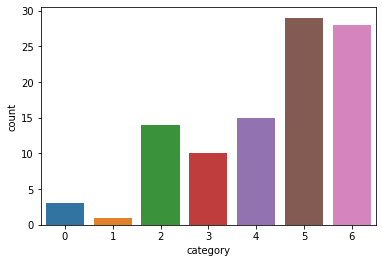

In [10]:
display(y.value_counts())
sns.countplot(x="category", data=clabels)

In [11]:
# The images are each (512 x 512), so these are arrays of the size of each file's images (512*512 = 262144 columns of pixels) 
data = np.zeros([100, 262144], dtype='uint8') # 118633 images, 262144 total pixels per image
size = []

# save the image path in its own dataframe then enumerate through the path list NOT the labels.
# then index and reindex the labels

m = 0
n = 0
counter = 0

for path, image in zip(clabels.image_path, clabels.Image):
    #print(n)
    if len(np.mean(matplotlib.image.imread(path + '/' + image),axis=2).reshape(-1)) == 262144:
        data[n,:] = np.mean(matplotlib.image.imread(path + '/' + image),axis=2).reshape(-1)
        m += 1
    else:
        size.append(m)
        display(path, image)
        print(m)
        counter += 1
        m += 1
        continue
    n += 1
print(counter)

0


In [12]:
display(size)

[]

In [13]:
final = clabels.drop(size)
final.reset_index(drop = True, inplace = True)
display(final)

,image_path,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,category
0,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_0002d9086.jpg,0,0,0,0,0,0,0
1,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_00227fb3a.jpg,0,0,0,0,0,0,0
2,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_00a421e28.jpg,0,0,0,0,0,0,0
3,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_013bff525.jpg,1,0,1,0,1,0,6
4,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_0aec3f605.jpg,1,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...
95,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_fa1c52d1f.jpg,1,0,0,0,1,1,6
96,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_fbe8892cc.jpg,1,0,0,0,1,0,4
97,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_fc464f1b3.jpg,1,0,0,0,1,1,6
98,C:/Users/ewild/Documents/School/2022 Spring/72...,ID_fda990c87.jpg,1,0,0,0,1,1,6


In [14]:
#data[0,:].sum(0)
#[row, column]
#display(data[118524:118632,:].sum())
#display(data[9679:9687,:].sum())
display(data[100:100,:].sum())

0

In [15]:
result = data[0:100]

In [16]:
#result = pd.DataFrame(result) # X
y_any = final["any"] # for the binary case

In [ ]:
result['any'] = y_any
display(result)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,  94,  94,  94],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [ 91, 100, 116, ..., 150, 150, 150],
       [105, 105, 104, ..., 120, 120, 120]], dtype=uint8)

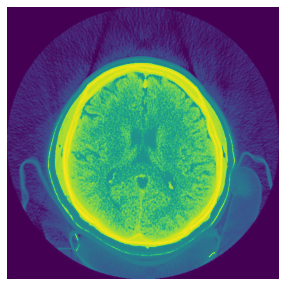

In [17]:
display(data)
plt.figure(figsize=(5,5));
plt.imshow(data[5].reshape(512,512));
plt.axis('off');

## Analysis

In [18]:
y = final['category']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(result, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(80, 262144) (20, 262144) (80,) (20,)


In [59]:
NUM_LABELS = 7

## We renormalize the training data since we do not need to flatten it
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

## We have to add an extra dimension to allow for the multiple images we will be creating
X_train = X_train.reshape(-1, 512, 512, 1)
X_test = X_test.reshape(-1, 512, 512, 1)

display(X_train.shape)
display(X_test.shape)

Y_train = np_utils.to_categorical(y_train, NUM_LABELS)
Y_test = np_utils.to_categorical(y_test, NUM_LABELS)

(80, 512, 512, 1)

(20, 512, 512, 1)

In [60]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [61]:
model = Sequential()

model.add(Conv2D(32, (128,128),
                 padding='valid',
                 input_shape=(512, 512, 1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (32,32),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(BatchNormalization())
model.add(Conv2D(128, (8,8),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
#model.add(Dense(units=490, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=NUM_LABELS, activation='softmax'))

opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.01)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 385, 385, 32)      524320    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 65, 64)        2097216   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                        

In [ ]:
history = model.fit(X_train, 
                    Y_train, 
                    epochs=5, 
                    batch_size=1,
                    verbose=1,
                    validation_data=(X_test, Y_test))

Epoch 1/5
80/80 [==============================] - 917s 11s/step - loss: 27.8781 - accuracy: 0.2250 - val_loss: 214.0360 - val_accuracy: 0.1500
Epoch 2/5
80/80 [==============================] - 939s 12s/step - loss: 31.2081 - accuracy: 0.2375 - val_loss: 511.4502 - val_accuracy: 0.2000
Epoch 3/5
29/80 [=========>....................] - ETA: 9:20 - loss: 1.9160 - accuracy: 0.2759

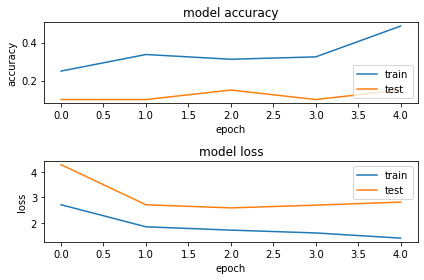

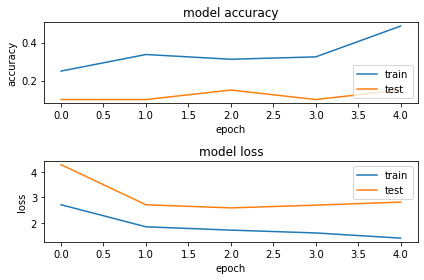

In [24]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

#### Logistic, LDA, QDA on the 7 Categories 

In [49]:
X_train, X_test, y_train, y_test = train_test_split(result, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(80, 262144) (20, 262144) (80,) (20,)


In [50]:
## Logistic Regression - with solver Stochastic Average Gradient descent
clf = LogisticRegression(solver = 'sag', max_iter = 100, n_jobs = 7, verbose = 1)
clf.fit(X_train,y_train)
print("Logistic Regression Score: %.3f"%clf.score(X_test,y_test))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


max_iter reached after 56 seconds
Logistic Regression Score: 0.200


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:   55.8s finished


In [51]:
## Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(store_covariance=False)
lda.fit(X_train, y_train)
print("LDA Score: %.3f"%lda.score(X_test,y_test))

LDA Score: 0.250


In [52]:
## Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis(store_covariance=False)
qda.fit(X_train, y_train)
print("QDA Score: %.3f"%qda.score(X_test,y_test))

QDA Score: 0.050


#### Logistic, LDA, QDA for the Normal/Non-normal Categories 

In [53]:
X_train, X_test, y_train, y_test = train_test_split(result, y_any, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(80, 262144) (20, 262144) (80,) (20,)


In [54]:
## Logistic Regression - with solver Stochastic Average Gradient descent
clf = LogisticRegression(solver = 'sag', max_iter = 100, n_jobs = 7, verbose = 1)
clf.fit(X_train,y_train)
print("Logistic Regression Score: %.3f"%clf.score(X_test,y_test))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


max_iter reached after 14 seconds
Logistic Regression Score: 0.950


[Parallel(n_jobs=7)]: Done   1 out of   1 | elapsed:   13.5s finished


In [55]:
## Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(store_covariance=False)
lda.fit(X_train, y_train)
print("LDA Score: %.3f"%lda.score(X_test,y_test))

LDA Score: 0.950


In [56]:
## Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis(store_covariance=False)
qda.fit(X_train, y_train)
print("QDA Score: %.3f"%qda.score(X_test,y_test))

QDA Score: 0.450
